In [1]:
import os
os.chdir('/Users/corentin/Documents/M2/BIPODS/Project/iPMCMC/ipmcmc')
%run generate_data.py
%run linear_gaussian_state_model
%run smc.py
%run csmc.py
%run ipmcmc.py

In [2]:

# 4.1. Linear Gaussian State Space Model
from scipy.spatial.transform import Rotation as R
np.random.seed(420)

# Parameters
r = R.from_rotvec(np.array([7*np.pi/10, 3*np.pi/10, np.pi/20]))
rotation_matrix = r.as_dcm()
scaling_matrix = 0.99*np.eye(3)
beta = np.random.dirichlet(np.ones(20)*0.2, 3).transpose()
alpha = scaling_matrix@rotation_matrix
t_max = 50
mu = np.array([0, 1, 1])
start_var = 0.1*np.eye(3)
omega = np.eye(3)
sigma = 0.1*np.eye(20)


n_particles = 100

linear_transition_model = [LinearMu(default_mean=mu, default_cov=start_var)]+[LinearTransition(default_mean=np.zeros(3),default_cov=omega,default_alpha=alpha) for t in range(1, t_max)]
linear_proposals = [LinearMu(default_mean=mu, default_cov=start_var)]+[LinearProposal(default_mean=np.zeros(3),default_cov=omega,default_alpha=alpha) for t in range(1, t_max)]
linear_observation_model = [LinearObservation(default_mean=np.zeros(20),default_cov=sigma,default_beta=beta) for t in range(0, t_max)]


# If we want to change the parameters
assert np.all(np.linalg.eigvals(start_var) > 0)
assert np.all(np.linalg.eigvals(omega) > 0)
assert np.all(np.linalg.eigvals(sigma) > 0)

l_states, l_observations = linear_gaussian_state_space(t_max=t_max, mu=mu, start_var=start_var, transition_var=omega, noise_var=sigma, transition_coeffs=alpha, observation_coeffs=beta)
display((l_states.shape, l_observations.shape))

((50, 3), (50, 20))

In [8]:
n_nodes = 32
n_conditional_nodes = 16
n_steps = 100
init_conditional_traj = np.zeros((n_conditional_nodes, t_max, len(mu)))

for i in range(n_conditional_nodes):
    particles, _, _ = smc(l_observations, n_particles,
       linear_transition_model, linear_proposals, linear_observation_model)
    init_conditional_traj[i] = particles.mean(axis=1)

In [9]:
particles, conditional_traj, weights, conditional_indices, zetas = ipmcmc(
    n_steps, n_nodes, n_conditional_nodes, l_observations, n_particles, init_conditional_traj,
    linear_proposals, linear_transition_model, linear_observation_model)

In [21]:
zetas.shape

(5, 16, 32)

In [10]:
from filterpy.kalman import KalmanFilter

fk = KalmanFilter(dim_x=3, dim_z=20)

fk.x = l_states[0]
fk.P = start_var

fk.F = alpha
fk.Q = omega

fk.H = beta
fk.R = sigma

mu_kal, cov_kal, _, _ = fk.batch_filter(l_observations)
means, covs, gain, predicted_covs = fk.rts_smoother(mu_kal, cov_kal)

In [15]:
w_barre = weights.mean(axis=2)

rao_black_traj = np.zeros((n_steps, n_conditional_nodes, t_max, len(mu)))
for r in range(n_steps):
    for p in range(n_conditional_nodes):
        for m in range(n_nodes):
            weighted_sum_parts = np.zeros((t_max, len(mu)))
            for n in range(n_particles):
                weighted_sum_parts += w_barre[r, m, n] * particles[r, m, :, n]
            weighted_zetas = zetas[r, p, m] * weighted_sum_parts
            rao_black_traj[r, p] += weighted_zetas

estimated_means_from_ipmcmc = np.mean(rao_black_traj, axis=(0,1))

In [40]:
def computeError(rao_black_traj, ground_truth, mcmc_step=100, state_step=None):
    if state_step is None:
        estimated_mean = np.mean(rao_black_traj[0:mcmc_step], axis=(0,1))
        return np.mean((estimated_mean - ground_truth)**2)
    else:
        estimated_mean = np.mean(rao_black_traj[:,:,0:state_step], axis=(0,1))
        return np.mean((estimated_mean - ground_truth[0:state_step])**2)


In [41]:
errors_function_of_mcmc_step = []
errors_function_of_state_step = []
for r in range(1, (n_steps+1)):
    errors_function_of_mcmc_step.append(computeError(rao_black_traj, means, r))
    
for t in range(1, (t_max+1)):
    errors_function_of_state_step.append(computeError(rao_black_traj, means, state_step=t))

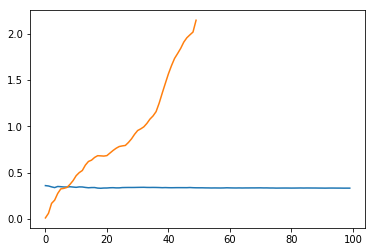

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.plot(np.log10(errors_function_of_mcmc_step))
plt.plot(errors_function_of_state_step)

In [43]:
errors_function_of_state_step


[0.009979301461982256,
 0.06001476457100232,
 0.16696534471198232,
 0.20180453651225816,
 0.27440887920765367,
 0.3237522386662659,
 0.32955474569803217,
 0.33926408495532884,
 0.372875583294166,
 0.41325264043525334,
 0.46648659715049867,
 0.49960848451794504,
 0.5223763827383697,
 0.5808551318741506,
 0.6202148474376687,
 0.6345088464322415,
 0.6637574876854543,
 0.6825750350354581,
 0.680739746855256,
 0.6783939399755715,
 0.6835929306964852,
 0.7113816741207367,
 0.7389044808030831,
 0.7630022790177452,
 0.7816277842004645,
 0.7883962796259079,
 0.793410571205778,
 0.8254903558349425,
 0.864529132121962,
 0.9138491501378122,
 0.9546411451657995,
 0.9724835353210556,
 0.9942733660601885,
 1.031327760912875,
 1.077902661083947,
 1.1120669663984024,
 1.1590735855116445,
 1.2508594606999321,
 1.3594921859321811,
 1.4638457697728042,
 1.5666499021348566,
 1.6552879245368317,
 1.7335543195926706,
 1.787037702340425,
 1.8428981604308776,
 1.9102124618642748,
 1.9572005211884873,
 1.988947